In [10]:
import os
import time
import argparse
import module
import numpy as np
import matplotlib.pyplot as plt
from model2 import Model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.nn.init as init

In [11]:
trial_num = 2
gene_num = 6
model_num = 4
tissue_num = 27
k_num = 5
lasso_alpha = 0.3

try:
    if not os.path.exists('../img/trial%d/gene%d/weight_plot'%(trial_num, gene_num)): 
        os.mkdir('../img/trial%d/gene%d/weight_plot'%(trial_num, gene_num))
except FileExistsError:
    print('Already exist folder')
    
gene_data_name = 'UTMOST_top10_Liver'
gene_list = os.listdir('../../%s/'%gene_data_name)
gene_name = gene_list[gene_num-1]

print('\n\n[Gene %d] Model %d ( tissue %d ) - %d/5 fold data'%(gene_num, model_num, tissue_num, k_num))
print('Option : lasso coeff : %.4f'%lasso_alpha)



[Gene 6] Model 4 ( tissue 27 ) - 5/5 fold data
Option : lasso coeff : 0.3000


In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

start_time = time.time()
np.random.seed(37)
torch.manual_seed(37)
torch.cuda.manual_seed_all(37)
torch.backends.cudnn.deterministic = True

snp, gx = module.load_data(gene_data_name, gene_name, tissue_num, proc=True)
snp_train, snp_test, gx_train, gx_test = module.k_fold_data(snp, gx, 5, k_num)

snp_train = torch.Tensor(snp_train).to(device)
snp_test = torch.Tensor(snp_test).to(device)
gx_train = torch.Tensor(gx_train).to(device)
gx_test = torch.Tensor(gx_test).to(device)

print('\nData shape @@@@@@')
print('Train data : ', np.shape(snp_train),' / ', np.shape(gx_train))
print('Test data : ', np.shape(snp_test), ' / ', np.shape(gx_test))
print('\n')


Data shape @@@@@@
Train data :  torch.Size([120, 27389])  /  torch.Size([120, 1])
Test data :  torch.Size([33, 27389])  /  torch.Size([33, 1])




In [4]:
learning_rate = 0.00003
model = Model(snp_len=snp_train.size()[-1], alpha=lasso_alpha).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

tr_loss_list = []
te_loss_list = []

tr_loss_buff = 0
te_loss_buff = 0
min_iter = 0

mb_div = 2
mb_idx = int(len(snp_train)/mb_div)
s = np.arange(len(snp_train))

for i in range(5001):
    np.random.shuffle(s)
    snp_train = snp_train[s]
    gx_train = gx_train[s]
    
    for mb in range(mb_div):
        dsnp_train = snp_train[mb*mb_idx:(mb+1)*mb_idx]
        dgx_train = gx_train[mb*mb_idx:(mb+1)*mb_idx]
        
        optimizer.zero_grad()
        tr_loss, output = model(dsnp_train, dgx_train)
        tr_loss.backward()
        optimizer.step()
    
    if i%100==0:
        tr_loss, output = model(snp_train, gx_train)
        te_loss, out_test = model(snp_test, gx_test)
        
        tr_loss_list.append(tr_loss.cpu().item())
        te_loss_list.append(te_loss.cpu().item())
        
    if i%100==0:
        print('iteration :', '%d/5000'%i, ' -  train loss :', \
              np.round(tr_loss.cpu().item(),3), '/  ', \
              'test loss :', np.round(te_loss.cpu().item(), 3))
        
        if te_loss_buff==0: te_loss_buff = te_loss.cpu().item(); continue
        
        if te_loss_buff>=te_loss.cpu().item():
            min_iter = i
            te_loss_buff = te_loss.cpu().item()
            tr_loss_buff = tr_loss.cpu().item()
            weight = model.fc1.weight.cpu().detach().numpy().reshape(-1)

iteration : 0/5000  -  train loss : 25.631 /   test loss : 24.731
iteration : 100/5000  -  train loss : 1.451 /   test loss : 0.911
iteration : 200/5000  -  train loss : 1.174 /   test loss : 0.661
iteration : 300/5000  -  train loss : 1.119 /   test loss : 0.68
iteration : 400/5000  -  train loss : 1.086 /   test loss : 0.698
iteration : 500/5000  -  train loss : 1.064 /   test loss : 0.713
iteration : 600/5000  -  train loss : 1.049 /   test loss : 0.723
iteration : 700/5000  -  train loss : 1.039 /   test loss : 0.734
iteration : 800/5000  -  train loss : 1.033 /   test loss : 0.741
iteration : 900/5000  -  train loss : 1.027 /   test loss : 0.747
iteration : 1000/5000  -  train loss : 1.024 /   test loss : 0.754
iteration : 1100/5000  -  train loss : 1.022 /   test loss : 0.758
iteration : 1200/5000  -  train loss : 1.02 /   test loss : 0.761
iteration : 1300/5000  -  train loss : 1.02 /   test loss : 0.765
iteration : 1400/5000  -  train loss : 1.018 /   test loss : 0.765
iteratio

189 84


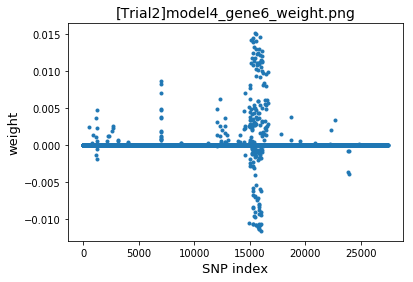

In [5]:
print(np.sum(weight>0.0001), np.sum(weight<-0.0001))
plt.title('[Trial%d]model%d_gene%d_weight.png'%(trial_num, model_num, gene_num), fontsize=14)
plt.plot(weight,'.')
plt.xlabel('SNP index', fontsize=13)
plt.ylabel('weight', fontsize=13)
plt.savefig('../img/trial%d/gene%d/weight_model%d_k%d.png'%(trial_num, gene_num, model_num, k_num))
plt.show()